
## Taller de Procesamiento de Señales - TP7 PCA
### Alumno: Julián Stejman

--- 

El dataset Fashion-MNIST fue cargado utilizando `load_data`, obteniéndose imágenes de entrenamiento y prueba de dimensiones 28x28. Se seleccionaron aleatoriamente 10 imágenes del conjunto de prueba y fueron visualizadas, identificándose claramente las categorías correspondientes a prendas de vestir.

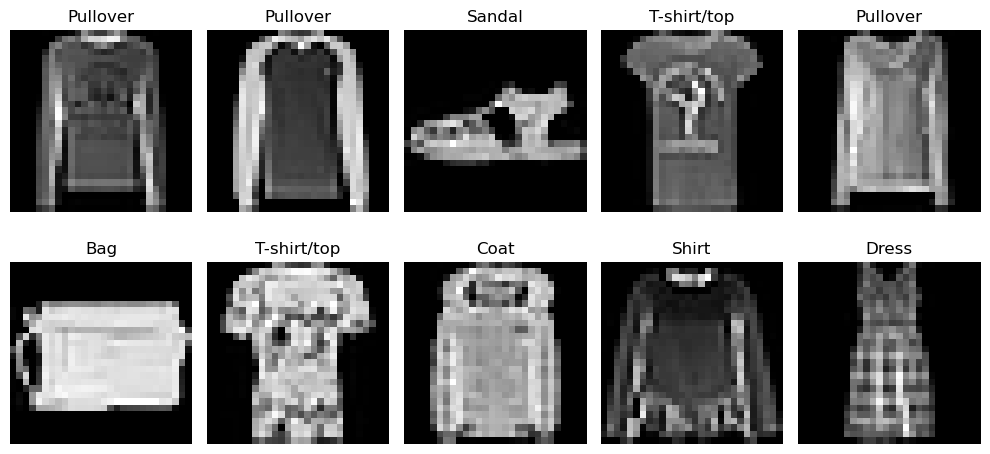

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

# Cargar los datos
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Nombres de las clases
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Visualizar 10 muestras aleatorias del conjunto de test
plt.figure(figsize=(10, 5))
random_indices = np.random.choice(len(test_images), 10, replace=False)

for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i+1)
    plt.imshow(test_images[idx], cmap='gray')
    plt.title(class_names[test_labels[idx]])
    plt.axis('off')

plt.tight_layout()
plt.show()

La clase PCA fue implementada siguiendo las consignas provistas. Los datos fueron previamente normalizados mediante la resta de la media y división por la desviación estándar. Los AVAS y AVES fueron calculados utilizando descomposición espectral de la matriz de covarianza. Los métodos transform e inverse_transform permitieron proyectar entre espacios de manera eficiente, mientras que transform_reconstruction optimizó los cálculos al reutilizar resultados previos.

In [5]:
class PCA:
    def __init__(self, normalize=True):
        self.mean = None
        self.std = None  # Nuevo: almacenar desviaciones estándar
        self.eigenvectors = None
        self.eigenvalues = None
        self.fitted = False
        self.umbral_reconstruccion = 5
        self.normalize = normalize  # Nuevo: parámetro para controlar estandarización
    
    def fit(self, X):
        # calcular media y desviación estándar
        self.mean = np.mean(X, axis=0)
        if self.normalize:
            self.std = np.std(X, axis=0)
            # Evitar división por cero (reemplazar ceros con 1)
            self.std[self.std == 0] = 1.0
        else:
            self.std = np.ones(X.shape[1])  # Sin escalamiento
        
        # normalizo los datos
        X_normalized = (X - self.mean) / self.std
        
        # matriz de covarianza
        cov_matrix = np.cov(X_normalized, rowvar=False)
        
        # autovalores y autovectores
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
        
        # ordenar autovalores y autovectores en orden descendente
        idx = eigenvalues.argsort()[::-1]
        self.eigenvalues = eigenvalues[idx]
        self.eigenvectors = eigenvectors[:, idx]
        self.fitted = True
    
    def transform(self, X, k):
        if not self.fitted:
            raise ValueError("Falta fittear")
        
        # Normalizar los nuevos datos con la media y std del entrenamiento
        X_normalized = (X - self.mean) / self.std
        return np.dot(X_normalized, self.eigenvectors[:, :k])
    
    def inverse_transform(self, U):
        if not self.fitted:
            raise ValueError("Falta fittear")
        
        # Reconstruir en el espacio normalizado y luego deshacer la normalización
        X_normalized = np.dot(U, self.eigenvectors[:, :U.shape[1]].T)
        return (X_normalized * self.std) + self.mean
    
    def fit_transform(self, X, k):
        self.fit(X)
        return self.transform(X, k)
    
    def transform_reconstruction(self, X, k, use_previous_results=False):
        if not self.fitted:
            raise ValueError("Falta fittear")
            
        if use_previous_results and hasattr(self, 'previous_reconstruction'):
            # si ya fue reconstruido se trabaja con los resultados previos
            prev_k = self.previous_reconstruction['k']
            
            # Si k es igual a prev_k, devolver la reconstrucción anterior
            if k == prev_k:
                return self.previous_reconstruction['reconstruction']
            
            elif k < prev_k:
                raise ValueError(f"El nuevo k ({k}) no puede ser menor que el anterior ({prev_k}).")
            else:
                # Si k > prev_k, dentro de un umbral razonable, se puede fittear unos componentes adicionales
                # si no conviene recalcular todo
                if k <= prev_k + self.umbral_reconstruccion: 
                    # Calcular solo los componentes adicionales necesarios
                    X_normalized = (X - self.mean) / self.std
                    additional_components = np.dot(X_normalized, self.eigenvectors[:, prev_k:k])
                    U = np.hstack([self.previous_reconstruction['U'], additional_components])
                    reconstruction = self.inverse_transform(U)
                    self._update_previous_results(U, reconstruction, k)
                    return reconstruction
                else:
                    # k es mucho mayor que prev_k, mejor recalcular todo
                    U = self.transform(X, k)
                    reconstruction = self.inverse_transform(U)
                    self._update_previous_results(U, reconstruction, k)
                    return reconstruction
        else:
            # Cálculo completo
            U = self.transform(X, k)
            reconstruction = self.inverse_transform(U)
            self._update_previous_results(U, reconstruction, k)
            return reconstruction

    def _update_previous_results(self, U, reconstruction, k):
        """Método helper para actualizar el estado"""
        self.previous_reconstruction = {
            'U': U,
            'reconstruction': reconstruction,
            'k': k
        }
    
    def fit_reconstruction(self, X, k):
        self.fit(X)
        return self.transform_reconstruction(X, k)

El porcentaje de energía acumulada fue calculado como la suma acumulada de AVES normalizados. Al graficar esta métrica en función del número de componentes, se observó que la mayor parte de la energía fue capturada con menos de 200 componentes. 

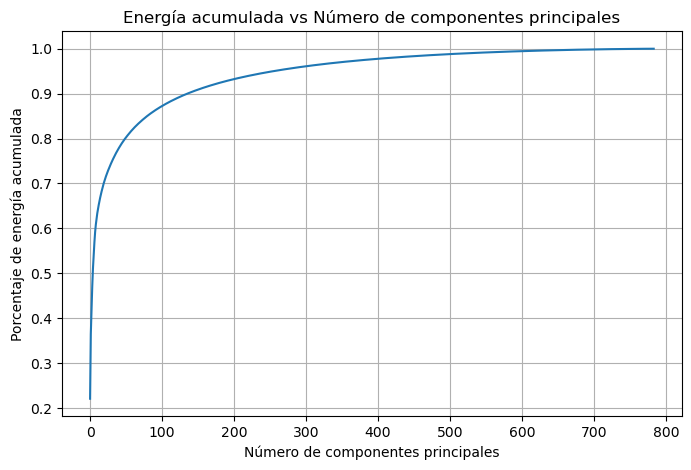

In [ ]:
# preprocesamiento de los datos
pixels = train_images.shape[1] * train_images.shape[2]
X_train = train_images.reshape(-1, pixels) / 255.0
X_test = test_images.reshape(-1, pixels) / 255.0

# entrenar pca
pca = PCA()
pca.fit(X_train)

# calcular energía acumulada
total_energy = np.sum(pca.eigenvalues)
energy_ratio = np.cumsum(pca.eigenvalues) / total_energy

# graficar
plt.figure(figsize=(8, 5))
plt.plot(energy_ratio)
plt.xlabel('Número de componentes principales')
plt.ylabel('Porcentaje de energía acumulada')
plt.title('Energía acumulada vs Número de componentes principales')
plt.grid()
plt.show()

El error de reconstrucción fue evaluado para diferentes valores de componentes principales. Para garantizar eficiencia computacional, las reconstrucciones con k+1 componentes aprovecharon los resultados previamente calculados con k componentes. 

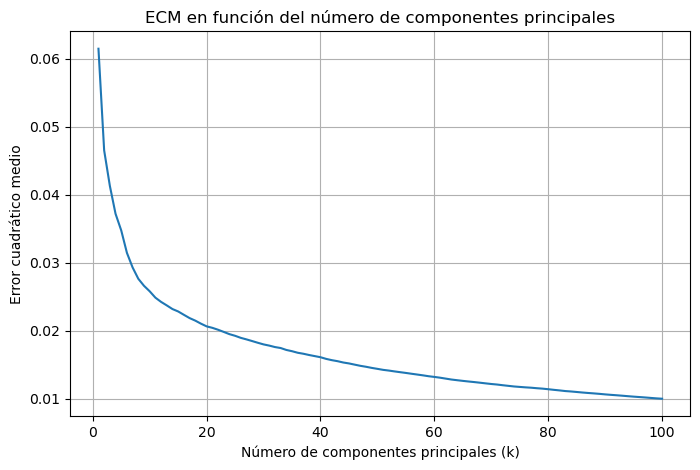

In [ ]:
def calculate_mse(X, X_recon):
    return np.mean((X - X_recon) ** 2)

mse_values = []
max_components = 100

for k in range(1, max_components + 1):
    X_recon = pca.transform_reconstruction(X_test, k, use_previous_results=True)
    mse = calculate_mse(X_test, X_recon)
    mse_values.append(mse)

plt.figure(figsize=(8, 5))
plt.plot(range(1, max_components + 1), mse_values)
plt.xlabel('Número de componentes principales (k)')
plt.ylabel('Error cuadrático medio')
plt.title('ECM en función del número de componentes principales')
plt.grid()
plt.show()

10 imágenes de prueba fueron seleccionadas aleatoriamente y reconstruidas utilizando distintas cantidades de componentes principales (1,100,784). Las reconstrucciones muestran que al subir la cantidad de componentes principales mejora también la calidad de las imágenes reconstruidas. 

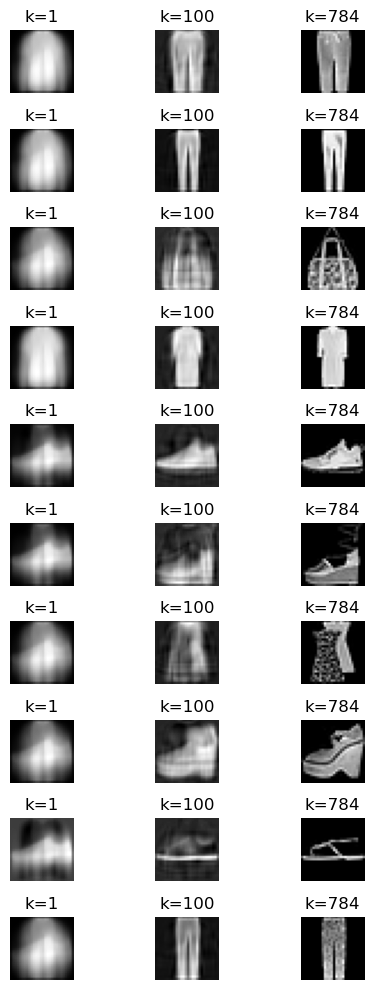

In [ ]:

random_indices = np.random.choice(len(X_test), 10, replace=False)
sample_images = X_test[random_indices]

# reconstruir con diferentes números de componentes
k_values = [1, 100, 784]
reconstructions = {}

for k in k_values:
    reconstructions[k] = pca.transform_reconstruction(sample_images, k)

plt.figure(figsize=(5, 10))
for i, idx in enumerate(random_indices):
    for j, k in enumerate(k_values):
        plt.subplot(10, len(k_values), i * len(k_values) + j + 1)
        if j == 0:
            plt.ylabel(f"Imagen {i+1}", rotation=0, ha='right', va='center')
        
        img = reconstructions[k][i].reshape(28, 28)
        plt.imshow(img, cmap='gray')
        plt.title(f"k={k}")
        plt.axis('off')

plt.tight_layout()
plt.show()

El detector de anomalías fue implementado combinando Fashion-MNIST (clase normal) y MNIST (clase anómala). El error de reconstrucción del PCA fue utilizado como métrica de decisión. Finalmente, el desempeño del detector fue evaluado mediante curvas ROC. Se puede ver que lo más óptimo se logra con k = 100 ya que su curva ROC es la más óptima de las 3. 

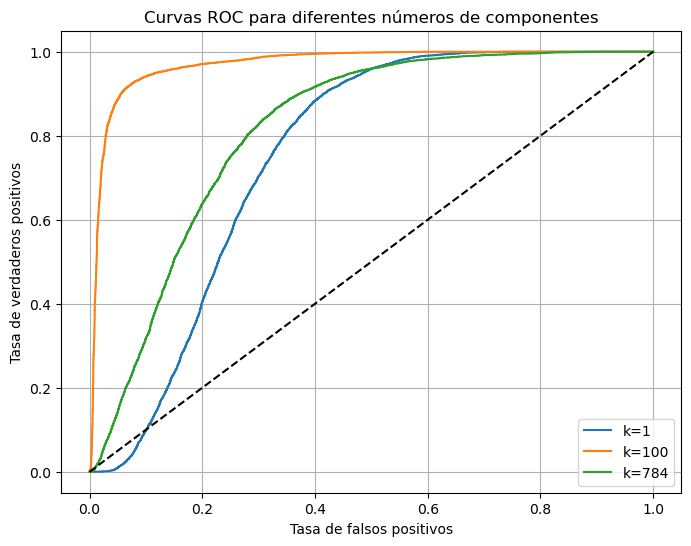

In [ ]:
from tensorflow.keras.datasets import mnist
from sklearn.metrics import roc_curve, auc

# Cargar MNIST como datos anómalos
(_, _), (mnist_images, _) = mnist.load_data()
mnist_images = mnist_images.reshape(-1, 784) / 255.0

# Conjunto combinado (Fashion-MNIST normal, MNIST anómalo)
X_combined = np.vstack([X_test, mnist_images])
y_true = np.hstack([np.zeros(len(X_test)), np.ones(len(mnist_images))])

# Detector de anomalías + ROC
def calculate_roc(pca, X, y_true, k):
    # Calcular errores de reconstrucción
    reconstructions = pca.transform_reconstruction(X, k)
    errors = np.mean((X - reconstructions) ** 2, axis=1)
    
    # Calcular curva ROC
    fpr, tpr, _  = roc_curve(y_true, errors)
    
    return fpr, tpr

k_values = [1, 100, 784]
roc_results = {}

plt.figure(figsize=(8, 6))
for k in k_values:
    fpr, tpr = calculate_roc(pca, X_combined, y_true, k)
    roc_results[k] = (fpr, tpr)
    plt.plot(fpr, tpr, label=f'k={k}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curvas ROC para diferentes números de componentes')
plt.legend()
plt.grid()
plt.show()